# Simulate acoustic wave propagation with multiple domains


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook shows the functionality to perform acoustic simulations when multiple domains are present.

## Import the OptimUS library

Load the OptimUS library. Make sure the source code is in the Python path.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

In [3]:
print("OptimUS version:", optimus.__version__)

OptimUS version: 0.0.0


## Specify the physical settings for the simulation

Let us consider two spherical objects embedded in an unbounded region of water. One of the domains consists of fat and the other of cortical bone. The incident plane wave has a frequency of 100 kHz and the two spheres have a radius of 7 and 5 mm, respectively.

In [4]:
frequency = 200e3
source = optimus.source.create_planewave(frequency, direction=(1,0,0))

In [5]:
radii = (7e-3, 5e-3)
origins = ((-10e-3,0,0), (10e-3,0,0))
meshwidth = 2e-3

In [6]:
geometry_left = optimus.geometry.shapes.Sphere(radius=radii[0], origin=origins[0], element_size=meshwidth)
geometry_right = optimus.geometry.shapes.Sphere(radius=radii[1], origin=origins[1], element_size=meshwidth)
geometries = (geometry_left, geometry_right)

In [7]:
geometries[0].label

'sphere'

A list of materials can be loaded at once.

In [8]:
material_ext = optimus.material.load_material('water')
materials_int = optimus.material.load_material(('fat', 'bone (cortical)'))
material_left, material_right = materials_int

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. The model with default settings needs the physical parameters as input. The interior domains are specified as a tuple or list of the geometries and the materials, while the exterior medium needs to be specified separately.

In [9]:
model = optimus.model.create_acoustic_model(source, geometries, material_ext, materials_int, 
                                            formulation='pmchwt',
                                            preconditioner='osrc')

Solving the model requires the GMRES algorithm to solve the system of boundary integral equations. This can be computationally expensive depending on the grid resolution.

In [10]:
model.solve()

## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

In [11]:
import numpy as np
import bempp.api
from matplotlib import pylab as plt

In [12]:
# Create a visualisation grid
Nx = 120
Ny = 160
xmin, xmax, ymin, ymax = [-20e-3, 30e-3, -15e-3, 20e-3]
zval = 0.0
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    zval*np.ones(plot_grid[0].size)))

# # Define the interior and exterior points
# x, y = points[:2]
# idx_left = np.sqrt((x-origins[0][0])**2 + (y-origins[0][1])**2) < radii[0]
# idx_right = np.sqrt((x-origins[1][0])**2 + (y-origins[1][1])**2) < radii[1]
# idx_ext = np.logical_not(np.logical_or(idx_left,idx_right))
# points_left = points[:, idx_left]
# points_right = points[:, idx_right]
# points_ext = points[:, idx_ext]

In [13]:
points.shape

(3, 19200)

In [14]:
pp = optimus.postprocess.method.PostProcess_2D(model,verbose=True)

In [15]:
pp.create_computational_grid(resolution=[Nx,Ny], plane_axes=[0,1], 
                             plane_offset=0, bounding_box=[-20e-3, 30e-3, -15e-3, 20e-3])


 Identifying the exterior and interior points Started at:  Fri, 24 Jun 2022 18:57:08
Element groups are:
[0]
Time to complete solid angle field parallelisation:  1.2902803421020508
Element groups are:
[0]
Time to complete solid angle field parallelisation:  1.1971850395202637

 Identifying the exterior and interior points Finished... Duration in secs:  2.8398211002349854


../optimus/postprocess/concave_hull.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


In [16]:
pp.points

array([[-0.02      , -0.02      , -0.02      , ...,  0.03      ,
         0.03      ,  0.03      ],
       [-0.015     , -0.01477987, -0.01455975, ...,  0.01955975,
         0.01977987,  0.02      ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [17]:
pp.index_interior[1].any()

True

In [18]:
pp.index_exterior.any()

True

In [19]:
pp.compute_fields()


 Calculating the interior and exterior potential operators Started at:  Fri, 24 Jun 2022 18:57:11
Calculating the fields of Domain 1
(3, 1629) (19200,) (872.5510125840678+0.7587801706029274j) <optimus.material.common.Material object at 0x7fdce2daee80>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  1.0252106189727783
Calculating the fields of Domain 2
(3, 806) (19200,) (357.5215180479361+10.910599999999999j) <optimus.material.common.Material object at 0x7fdce2daedd8>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  1.4932224750518799

 Calculating the incident field Started at:  Fri, 24 Jun 2022 18:57:13

 Calculating the incident field Finished... Duration in secs:  0.013148069381713867


In [20]:
pp.total_field.shape

(19200,)

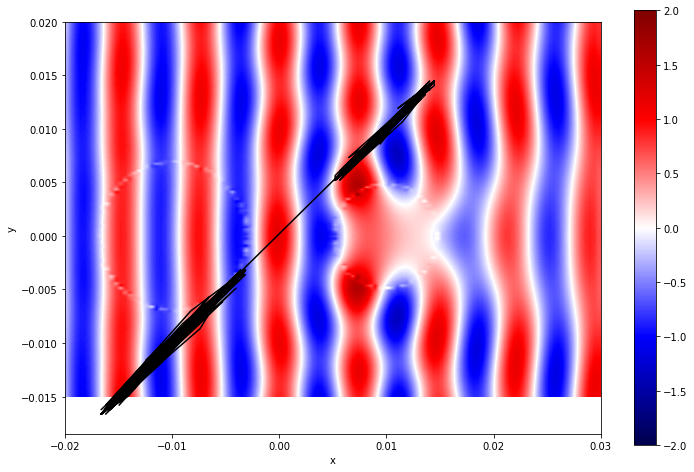

In [52]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(np.real(pp.total_field_reshaped), extent=(xmin, xmax, ymin, ymax), clim=(-2,2), cmap='seismic', 
           interpolation='bilinear')
# plt.plot(np.asanyarray(pp.domains_edges)[:,0,0],np.asanyarray(pp.domains_edges)[:,0,1], 'k')
# plt.plot(origins[1][0]+radii[1]*np.cos(theta), origins[1][1]+radii[1]*np.sin(theta), 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [22]:
pp.create_computational_grid.__defaults__

([141, 141], [0, 1], 0.0, [])

In [23]:
ppu = optimus.postprocess.method.PostProcess_USER_DEFINED(model,verbose=True)

In [24]:
ppu.create_computational_grid(resolution=[Nx,Ny],user_points=points)


 Identifying the exterior and interior points Started at:  Fri, 24 Jun 2022 18:57:13
Element groups are:
[0]


../optimus/postprocess/method.py:215: RuntimeWarning: The user-defined points will be used for field calculations.
  RuntimeWarning,


Time to complete solid angle field parallelisation:  1.1346919536590576
Element groups are:
[0]
Time to complete solid angle field parallelisation:  1.2029287815093994

 Identifying the exterior and interior points Finished... Duration in secs:  2.6862246990203857


In [25]:
ppu.compute_fields()


 Calculating the interior and exterior potential operators Started at:  Fri, 24 Jun 2022 18:57:16
Calculating the fields of Domain 1
(3, 1629) (19200,) (872.5510125840678+0.7587801706029274j) <optimus.material.common.Material object at 0x7fdce2daee80>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  1.0176806449890137
Calculating the fields of Domain 2
(3, 806) (19200,) (357.5215180479361+10.910599999999999j) <optimus.material.common.Material object at 0x7fdce2daedd8>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  1.4834504127502441

 Calculating the incident field Started at:  Fri, 24 Jun 2022 18:57:17

 Calculating the incident field Finished... Duration in secs:  0.014087677001953125


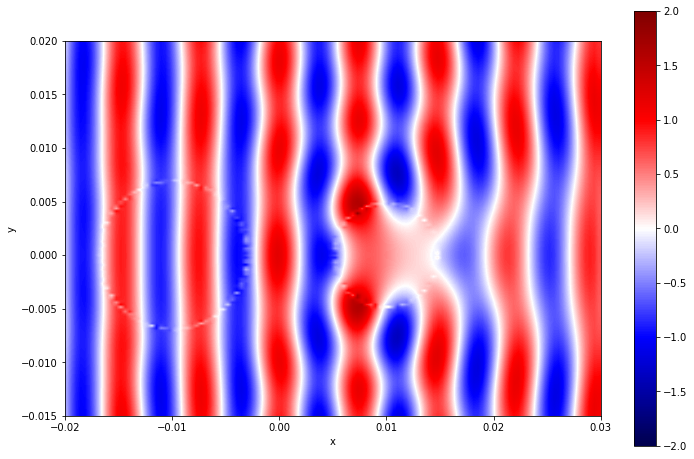

In [26]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(np.real(ppu.total_field_reshaped), extent=(xmin, xmax, ymin, ymax), clim=(-2,2), cmap='seismic', 
           interpolation='bilinear')
theta = np.linspace(0, 2*np.pi, 100)
# plt.plot(origins[0][0]+radii[0]*np.cos(theta), origins[0][1]+radii[0]*np.sin(theta), 'k')
# plt.plot(origins[1][0]+radii[1]*np.cos(theta), origins[1][1]+radii[1]*np.sin(theta), 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [27]:
pp3d = optimus.postprocess.method.PostProcess_3D(model,verbose=True)

In [28]:
pp3d.create_computational_grid(resolution=[Nx,Ny], plane_axes=[0,1], 
                               plane_offset=0, bounding_box=[-20e-3, 30e-3, -15e-3, 20e-3])


 Identifying the exterior and interior points Started at:  Fri, 24 Jun 2022 18:57:23
Element groups are:
[0]
Time to complete solid angle field parallelisation:  1.9548735618591309
Element groups are:
[0]
Time to complete solid angle field parallelisation:  1.9602055549621582

 Identifying the exterior and interior points Finished... Duration in secs:  4.658021688461304


In [29]:
pp3d.compute_fields()


 Calculating the interior and exterior potential operators Started at:  Fri, 24 Jun 2022 18:57:28
Calculating the fields of Domain 1
(3, 4143) (48784,) (872.5510125840678+0.7587801706029274j) <optimus.material.common.Material object at 0x7fdce2daee80>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  15.893617153167725
Calculating the fields of Domain 2
(3, 2067) (48784,) (357.5215180479361+10.910599999999999j) <optimus.material.common.Material object at 0x7fdce2daedd8>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  21.927408695220947

 Calculating the incident field Started at:  Fri, 24 Jun 2022 18:57:50

 Calculating the incident field Finished... Duration in secs:  0.014800071716308594


In [49]:
np.asanyarray(pp.domains_edges)[:,0,0]

array([-0.00319328, -0.01621849, -0.01159664, -0.01663866, -0.00571429,
       -0.00319328, -0.01663866, -0.00907563, -0.00319328, -0.00613445,
       -0.00529412, -0.00907563, -0.00319328, -0.00991597, -0.01663866,
       -0.01663866, -0.00319328, -0.01201681, -0.01663866, -0.01663866,
       -0.01411765, -0.0107563 , -0.0094958 , -0.01327731, -0.01369748,
       -0.01453782, -0.0094958 , -0.01663866, -0.01663866, -0.00529412,
       -0.01621849, -0.00361345, -0.00319328, -0.01243697, -0.00697479,
       -0.01663866, -0.01663866, -0.00319328, -0.00991597, -0.01663866,
       -0.00361345, -0.01663866, -0.01663866, -0.00319328, -0.01117647,
       -0.01579832, -0.00655462, -0.0107563 , -0.00697479, -0.00319328,
       -0.00319328, -0.01663866, -0.01537815, -0.00823529, -0.00487395,
       -0.00739496, -0.01663866, -0.01285714, -0.01579832, -0.01033613,
       -0.01033613, -0.00445378, -0.01369748, -0.00487395, -0.01663866,
       -0.01411765, -0.00319328, -0.01663866, -0.00655462, -0.01

In [44]:
pp.points_interior[0][[0,1],:]

array([[-0.01663866, -0.01663866, -0.01663866, ..., -0.00319328,
        -0.00319328, -0.00319328],
       [-0.00179245, -0.00157233, -0.0013522 , ...,  0.00084906,
         0.00106918,  0.00128931]])

In [45]:
def domain_edge(points_interior, plane_axes, alpha=0.005, only_outer=True):
    """This function determines the points on the edges of the domains using the Concave Hull method.
    alpha: the threshhold value.
    only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    """

    from .concave_hull import concave_hull as _concave_hull

    domains_edge_points = []
    for k in range(len(points_interior)):
        points_int_planar = points_interior[k][plane_axes, :]
        edges = _concave_hull(points_int_planar.T, alpha, only_outer)
        for i, j in edges:
            domains_edge_points.append(
                np.vstack([points_int_planar[0, [i, j]], points_int_planar[1, [i, j]]])
            )

    return domains_edge_points